Universe size: 4 | Start: 2010-01-01


[*********************100%***********************]  4 of 4 completed

Tickers: ['0939.HK', '1288.HK', '1398.HK', '3988.HK'] ... total: 4
Top 10 by Sharpe:


,Sharpe,MaxDD,Turnover/yr,HitRate,AnnRet,AnnVol
3988.HK,0.087007,-0.099502,11.193991,0.039268,0.002913,0.033479
0939.HK,-0.318327,-0.241152,11.091863,0.045370,-0.010642,0.033432
1398.HK,-0.638620,-0.329882,11.514817,0.038206,-0.022121,0.034638
1288.HK,-0.670767,-0.345777,11.880609,0.037941,-0.023150,0.034513


=== Equal-weight Portfolio ===
Sharpe: -0.55 | MaxDD: -23.69% | AnnRet: -1.33% | AnnVol: 2.41%


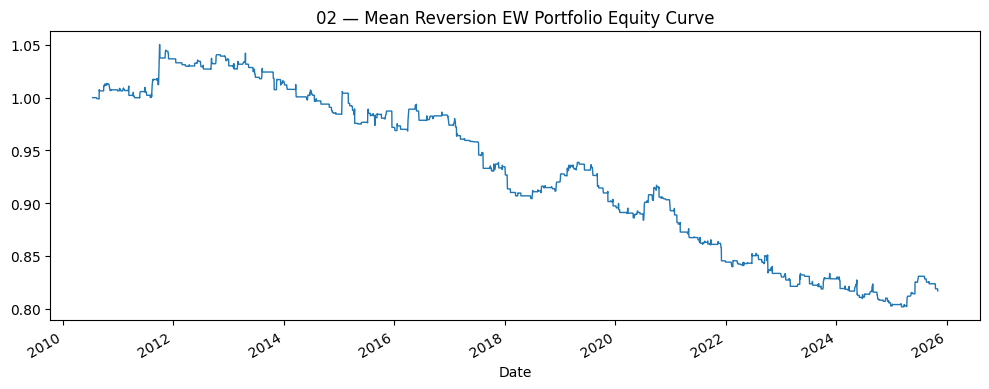

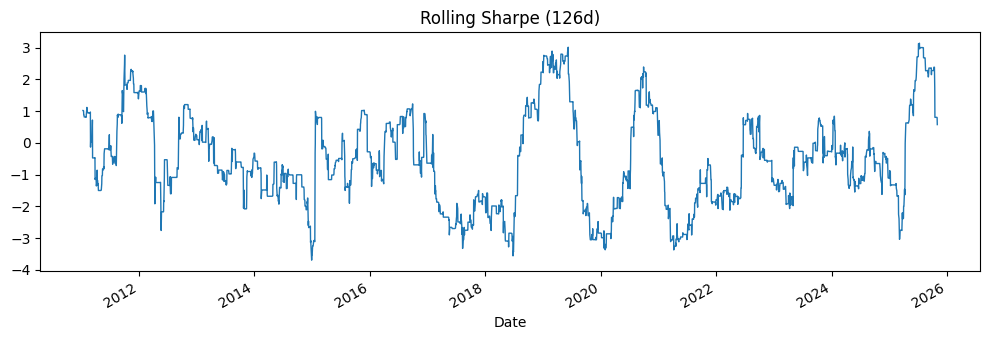

In [1]:
# Mean Reversion — 02_single_stock_zscore
# Build rolling z-score signals on DAILY returns, trade reversals,
# apply volatility scaling and transaction costs, and evaluate.

# --- Setup ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

PDAYS = 252

# --- Load data ---

banks = ['1398.HK', '0939.HK', '3988.HK', '1288.HK']

TICKERS = banks
START = "2010-01-01"


print(f"Universe size: {len(TICKERS)} | Start: {START}")

# 2) Download Adjusted Close Prices
# We prefer 'Adj Close' to reflect total-return adjustments
raw = yf.download(TICKERS, start=START, auto_adjust=False, progress=True).dropna()
prices = raw["Adj Close"].sort_index()

returns = np.log(prices / prices.shift(1)).replace([np.inf, -np.inf], np.nan)

returns = returns.dropna(how="all")
tickers = list(returns.columns)
print("Tickers:", tickers[:10], "... total:", len(tickers))

# --- Config (feel free to tweak) ---
ROLL_WIN   = 10          # rolling window for z-score (5–20 typical)
HOLD_MAX   = 5           # max holding days (1–5 typical)
Z_ENTRY    = 2.0         # |z| threshold to enter
TC_BPS     = 5           # round-trip cost in bps (use 1–10 bps for liquid names)
TARGET_ANN_VOL = 0.10    # portfolio target annual vol (optional)
VOL_WIN    = 20          # rolling window for vol scaling

UNIVERSE   = tickers     # or select a subset, e.g. ['AAPL','MSFT', '0939.HK', '1398.HK']

# --- Helpers ---
def sharpe_annualized(r: pd.Series | pd.DataFrame, periods=PDAYS):
    m = r.mean() * periods
    s = r.std(ddof=0) * np.sqrt(periods)
    return m / s

def max_drawdown(cum_curve: pd.Series):
    peak = cum_curve.cummax()
    dd = cum_curve / peak - 1.0
    return dd.min()

def turnover_series(pos: pd.Series):
    return pos.diff().abs().fillna(0.0)

def zscore(x: pd.Series, win: int):
    m = x.rolling(win, min_periods=win).mean()
    s = x.rolling(win, min_periods=win).std(ddof=0)
    return (x - m) / s

def vol_target_weights(sig: pd.Series, ret: pd.Series, vol_win=20, target_ann_vol=0.10):
    """
    Scale signal to hit daily vol target using rolling realized vol of asset.
    weight_t = sig_t * (target_daily_vol / (asset_vol_t + eps))
    """
    eps = 1e-8
    daily_target = target_ann_vol / np.sqrt(PDAYS)
    asset_vol = ret.rolling(vol_win, min_periods=vol_win).std(ddof=0)
    scale = daily_target / (asset_vol + eps)
    return sig * scale.clip(upper=10.0)  # cap extreme scaling

# --- Single-asset backtest with entry/exit rules ---
def backtest_single_ticker(r: pd.Series,
                           roll_win=10,
                           hold_max=5,
                           z_entry=2.0,
                           tc_bps=5,
                           do_vol_target=True,
                           vol_win=20,
                           target_ann_vol=0.10):
    """
    Signal: z-score of DAILY returns.
      - Enter long if z < -z_entry; enter short if z > +z_entry
      - Exit when z crosses 0 OR after hold_max days
    Position is in {-1, 0, +1} before vol-targeting. Then optionally scaled.
    TC: applied on position change (one-way = tc_bps/2 each side).
    """
    z = zscore(r, roll_win)
    pos_raw = pd.Series(0.0, index=r.index)
    holding_days = 0

    state = 0  # -1 short, 0 flat, +1 long
    for t in range(len(r)):
        if np.isnan(z.iat[t]):
            pos_raw.iat[t] = state
            continue

        zt = z.iat[t]

        if state == 0:
            if zt < -z_entry:
                state, holding_days = +1, 1
            elif zt > +z_entry:
                state, holding_days = -1, 1
        else:
            exit_cond = (zt * state <= 0) or (holding_days >= hold_max)
            if exit_cond:
                state, holding_days = 0, 0
            else:
                holding_days += 1

        pos_raw.iat[t] = state

    # Volatility targeting (optional)
    if do_vol_target:
        pos = vol_target_weights(pos_raw, r, vol_win=vol_win, target_ann_vol=target_ann_vol)
    else:
        pos = pos_raw.copy()

    # Transaction costs: apply on |Δpos|
    # Convert bps to return cost: cost = abs(Δpos) * (tc_bps * 1e-4)
    dpos = pos.fillna(0).diff().abs().fillna(0)
    tc = dpos * (tc_bps * 1e-4)

    strat_ret = (pos.shift(1).fillna(0) * r) - tc  # enter at close-next open approx
    out = pd.DataFrame({
        "ret": strat_ret,
        "pos": pos,
        "pos_raw": pos_raw,
        "z": z
    })
    return out

# --- Run per-ticker and collect metrics ---
perfs = {}
equity_curves = []

for tik in UNIVERSE:
    series = returns[tik].dropna()
    if series.size < max(ROLL_WIN, VOL_WIN) + 30:
        continue

    bt = backtest_single_ticker(series,
                                roll_win=ROLL_WIN,
                                hold_max=HOLD_MAX,
                                z_entry=Z_ENTRY,
                                tc_bps=TC_BPS,
                                do_vol_target=True,
                                vol_win=VOL_WIN,
                                target_ann_vol=TARGET_ANN_VOL)

    eq = (1 + bt["ret"].fillna(0)).cumprod()
    equity_curves.append(eq.rename(tik))

    sr = sharpe_annualized(bt["ret"])
    mdd = max_drawdown(eq)
    to = turnover_series(bt["pos"]).mean() * PDAYS  # annualized turnover (avg |Δpos| * 252)
    hit = (bt["ret"] > 0).mean()

    perfs[tik] = {
        "Sharpe": float(sr),
        "MaxDD": float(mdd),
        "Turnover/yr": float(to),
        "HitRate": float(hit),
        "AnnRet": float(bt["ret"].mean() * PDAYS),
        "AnnVol": float(bt["ret"].std(ddof=0) * np.sqrt(PDAYS))
    }

perf_df = pd.DataFrame(perfs).T.sort_values("Sharpe", ascending=False)
print("Top 10 by Sharpe:")
display(perf_df.head(10))

# --- Equal-weight portfolio of all tickers (simple aggregate) ---
if equity_curves:
    eq_df = pd.concat(equity_curves, axis=1).dropna(how="all")
    # Build portfolio by averaging RETURNS (not equity curves)
    aligned_rets = []
    for tik in eq_df.columns:
        # rebuild returns from each ticker backtest to align dates
        r = returns[tik].dropna()
        bt = backtest_single_ticker(r,
                                    roll_win=ROLL_WIN,
                                    hold_max=HOLD_MAX,
                                    z_entry=Z_ENTRY,
                                    tc_bps=TC_BPS,
                                    do_vol_target=True,
                                    vol_win=VOL_WIN,
                                    target_ann_vol=TARGET_ANN_VOL)
        aligned_rets.append(bt["ret"].rename(tik))
    port_ret = pd.concat(aligned_rets, axis=1).mean(axis=1).dropna()
    port_eq  = (1 + port_ret).cumprod()

    # Metrics
    port_sr  = sharpe_annualized(port_ret)
    port_mdd = max_drawdown(port_eq)
    port_ann = port_ret.mean() * PDAYS
    port_vol = port_ret.std(ddof=0) * np.sqrt(PDAYS)

    print("=== Equal-weight Portfolio ===")
    print(f"Sharpe: {port_sr:.2f} | MaxDD: {port_mdd:.2%} | AnnRet: {port_ann:.2%} | AnnVol: {port_vol:.2%}")

    # Plots
    plt.figure(figsize=(10,4))
    port_eq.plot(lw=1)
    plt.title("02 — Mean Reversion EW Portfolio Equity Curve")
    plt.tight_layout()
    plt.show()

    # Rolling Sharpe (126d)
    roll = 126
    rs = (port_ret.rolling(roll).mean() / port_ret.rolling(roll).std(ddof=0)) * np.sqrt(PDAYS)
    plt.figure(figsize=(10,3.5))
    rs.plot(lw=1)
    plt.title("Rolling Sharpe (126d)")
    plt.tight_layout()
    plt.show()


In [2]:
# Optional: save per-ticker last z-scores for inspection
last_z = {}
for tik in UNIVERSE:
    s = returns[tik].dropna()
    if s.size >= ROLL_WIN:
        last_z[tik] = zscore(s, ROLL_WIN).iloc[-1]
last_z = pd.Series(last_z).sort_values()
display(last_z.to_frame("z_last"))

# --- Notes ---
print(
    "Notes:\n"
    f"- Entry |z|>{Z_ENTRY}, exit at z*pos<=0 or after {HOLD_MAX} days.\n"
    f"- Costs: {TC_BPS} bps round-trip applied on |Δposition|.\n"
    f"- Vol targeting to {TARGET_ANN_VOL:.0%} annual vol using {VOL_WIN}-day rolling vol.\n"
    "- Next: tune (ROLL_WIN, HOLD_MAX, Z_ENTRY) and run subperiod robustness in Notebook 05."
)


,z_last
0939.HK,-2.283366
3988.HK,-1.959366
1288.HK,-1.847752
1398.HK,-0.846734


Notes:
- Entry |z|>2.0, exit at z*pos<=0 or after 5 days.
- Costs: 5 bps round-trip applied on |Δposition|.
- Vol targeting to 10% annual vol using 20-day rolling vol.
- Next: tune (ROLL_WIN, HOLD_MAX, Z_ENTRY) and run subperiod robustness in Notebook 05.
